# Фабарисов Дмитрий. Выпуклый анализ и оптимизация. Задание 2.

In [44]:
import cvxopt as cp
cp.solvers.options['show_progress'] = False

from scipy import optimize as opt
import time
import copy as cp
import numpy as np
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Создадим вспомогательные функции

$\frac {\partial f} {\partial x_1} = \frac {x_1 - 1} {2} + 8 x_1 (2 x_1^2 - x_2 - 1)$ 

$\frac {\partial f} {\partial x_n} = - 2(2 x_{n-1}^2 - x_n - 1)$

$\frac {\partial f} {\partial x_i} = 8 x_i (2 x_i^2 - x_{i+1} - 1) - 2(2 x_{i-1}^2 - x_i - 1),\ \ \ \ i = 2, ..., n - 1$

$$f'' (x) =
\begin{pmatrix}
48 x_1^2 - 8 x_2 - 7.5 & -8 x_1 & 0 & ... & 0 & 0\\
-8 x_1 & 48 x_2^2 - 8 x_3 - 6 & -8 x_2 & ... & 0 & 0\\
0 & -8 x_2 & 48 x_3^2 - 8 x_4 - 6 & ... & 0 & 0\\
... & & & & & \\
0 & 0 & 0 & ... & 48 x_{n-1}^2 - 8 x_n - 6 & -8 x_{n-1} \\
0 & 0 & 0 & ... & -8 x_{n-1} & 2 \\
\end{pmatrix}$$

In [45]:
def check_difference(func, grad_func, f_true, x, x_true):
    delta_x = np.linalg.norm(x - x_true)
    delta_func = np.abs(func(x) - f_true)
    abs_grad = np.linalg.norm(grad_func(x))
    
    return delta_x, delta_func, abs_grad 

In [46]:
def func(x):
    l = len(x)
    res = 0
    res += (x[0] - 1)**2 / 4
    for i in range(1, l):
        res += (2 * x[i-1]**2 - x[i] - 1) ** 2
    return res

In [47]:
def grad_func(x):
    l = len(x)
    grad = np.zeros(l)
    grad[0] = 16*x[0]**3 - 8*x[0]*x[1] - 7.5*x[0] - 0.5
    grad[l-1] = -4*x[l-2]**2 + 2*x[l-1] + 2
    for i in range(1, l-1):
        grad[i] = 16*x[i]**3 - 4*x[i-1]**2 - 8*x[i]*x[i+1] - 6*x[i] + 2
    
    return grad

In [48]:
def hess_func(x):
    n = len(x)
    hess = np.zeros([n, n])
    hess[0,0] = 48*x[0]**2 - 8*x[1] - 7.5
    hess[0,1] = -8*x[0]
    hess[1,0] = hess[0,1]
    hess[n-1, n-1] = 2
    hess[n-1, n-2] = -8*x[n-2]
    hess[n-2, n-1] = hess[n-1, n-2]
    for i in range(1, n-1):
        hess[i, i] = 48*x[i]**2 - 8*x[i+1] - 6
        
        hess[i, i-1] = -8*x[i-1]
        hess[i, i+1] = -8*x[i+1]
        
        hess[i-1, i] = hess[i, i-1]
        hess[i+1, i] = hess[i, i+1]
    
    return np.matrix(hess)

## Задаем размерность, генерируем $x$, задаем истинные значения минимума $x_{true}$, $y_{true}$.

In [49]:
dimension = 100
x = [-1.5] + [1.0]*(dimension - 1)

x_true = [1.0] * dimension
f_true = 0.0

## Отобразим линии уровня для двумерного случая

<a list of 221 text.Text objects>

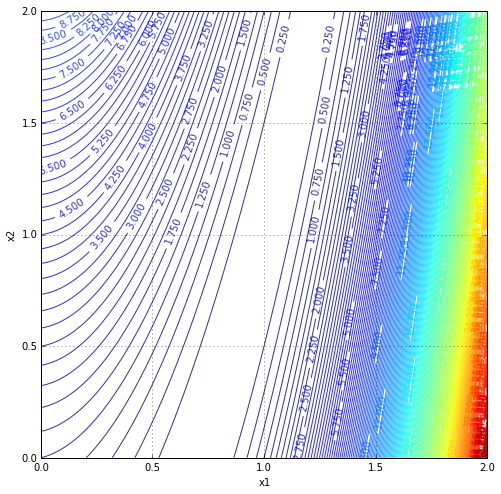

In [50]:
x1 = linspace(0, 2, 500)
x2 = linspace(0, 2, 500)
xx1, xx2 = meshgrid(x1, x2)

f = 0.25*(xx1 - 1)**2 + (2*xx1**2 - xx2 - 1)**2

constr3 = (xx2 <= -5)

figure(figsize=(8, 8))
grid(True)
xlabel('x1')
ylabel('x2')

CS = contour(x1, x2, f, 200, alpha=0.8)
plt.clabel(CS, CS.levels)
#contourf(x1, x2, constr1, 1, alpha=0.5, linewidths=4, cmap='autumn')

## Метод градиентного спуска

In [51]:
def gradient_descent(max_time=10, x0=x, func=func, x_true=x_true, f_true=f_true, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8)):
    start = time.time()
    x = np.array(x0)
    step = 0.001
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        
        x -= step * grad_func(x)
        i += 1

## Метод сопряженных градиентов

In [84]:
def conjugate_gradient(max_time=10, x0=x, func=func, x_true=x_true, f_true=f_true, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8)):
    start = time.time()
    x = np.array(x0)
    i = 0
    S = -grad_func(x)
    new_grad = -S
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        def func_lambd(lambd):
            return func(x + lambd * S)
        prev_grad = new_grad
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        new_grad = grad_func(x)
        w = np.linalg.norm(new_grad)**2 / np.linalg.norm(prev_grad)**2
        S = -new_grad + w*S
        i += 1

## Метод наискорейшего спуска

In [53]:
def optimal_gradient_descent(max_time=10, x0=x, func=func, x_true=x_true, f_true=f_true, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8)):
    start = time.time()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        
        S = -grad_func(x)
        def func_lambd(lambd):
            return func(x + lambd * S)
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        i += 1

In [54]:
#print optimal_gradient_descent(x, func, x_true, f_true, grad_func, check_difference, 10 ** (-8), 10)

## Метод Ньютона

In [55]:
def newton_method(max_time=10, x0=x, func=func, x_true=x_true, f_true=f_true, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8)):
    start = time.time()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1]]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1]]
        micro_step = 0.001
        S = grad_func(x)
        H = hess_func(x)
        res = H.I * np.matrix(S).T
        x -= np.asarray(res).ravel()
        i += 1

## Напишем тестирующую функцию, принимающую максимальное время работы и подбирающую максимальную размерность, с которой метод еще может справиться.

In [90]:
def test_method(method, dimension = 2, max_time=60, x_true=x_true, f_true=f_true, func=func, grad_func=grad_func, hess_func=hess_func, check_difference=check_difference, tol=10**(-8)):
    
    x = [-1.5] + [1.0]*(dimension - 1)
    x_true = [1.0] * dimension
    f_true = 0.0
    
    flag = 1
    while(flag):
        print "dimension = ", dimension
        res = method(max_time, x, func, x_true)
        flag = res[0]
        if (flag):
            dimension *= 2
            x = [-1.5] + [1.0]*(dimension - 1)
            x_true = [1.0] * dimension
        else:
            dimension /= 2
            return dimension, res

In [85]:
methods = [gradient_descent, conjugate_gradient, optimal_gradient_descent, newton_method]

In [58]:
test_method(methods[0], 2 , 60)

dimension =  2
dimension =  4


2

In [59]:
test_method(methods[1], 2, 60)

dimension =  2
dimension =  4
dimension =  8
dimension =  16
dimension =  32
dimension =  64
dimension =  128
dimension =  256
dimension =  512
dimension =  1024
dimension =  2048
dimension =  4096
dimension =  8192
dimension =  16384
dimension =  32768
dimension =  65536
dimension =  131072


65536

In [60]:
test_method(methods[2], 2, 60)

dimension =  2
dimension =  4


2

In [61]:
test_method(methods[3], 2, 60)

dimension =  2
dimension =  4


2

## Теперь мы знаем размерности задач. Проверим, для 0, 2 и 3 метода размерность 3

In [79]:
test_method(methods[0], 3, 60)

dimension =  3


1

In [87]:
test_method(methods[2], 3, 60)

dimension =  3


1

In [88]:
test_method(methods[3], 3, 60)

dimension =  3


1

## Получаем вывод, что следует создавать таблицу и графики для $n = 2$ для методов 0, 2, 3 и $n = 65536$ для метода 1.

## Научимся генерировать "портящую" матрицу $P$. 

Нам нужна положительно определенная плохо обусловленная матрица с $\frac{\lambda_{max}}{\lambda_{min}} \sim 10^6$.

Создадим диагональную матрицу $D$, такую что $\frac{\max{D_{ii}}}{\min{D_{ii}}} \sim 10^6$. Затем умножим её на слева на $V$ и справа на $V^T$, где $V^T = V^{-1}$ - ортогональная матрица.

Ортогональную матрицу получим из QR разложения рандомной матрицы на ортогональную и верхнетреугольную.

После всего этого получим матрицу $P = VDV^T$, удовлетворяющую необходимым свойствам.

In [62]:
np.random.seed(2)
temp = np.random.randn(10000).reshape((100, 100))
Q, R = np.linalg.qr(temp)
P = Q.T.dot(np.diagflat([10**6] + [1]*99)).dot(Q)

## Создадим вспомогательные функции для второй части

$$ f(x) = \sum\limits_{i=1}^n e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial f}{\partial x_i} = - e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial^2 f}{\partial x_i \partial x_j} = e^{-x_i} \delta_{ij} + e^{\sum x_i - 1} $$

$$x_{i}^{opt} = \frac{1}{n+1}$$

$$f(x_{opt}) = (n+1) e^{- \frac{1}{n+1}}$$

In [63]:
def func2(x):
    return np.sum(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1)

def bad_func2(x):
    return func2(P.dot(x))

def grad_func2(x):
    return - np.power(np.e, -x) + np.power(np.e, np.sum(x) - 1)

def bad_grad_func2(x):
    return P.dot(grad_func2(P.dot(x)))

def hess_func2(x):
    return np.matrix(np.diagflat(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1))

def opt_x(dimension):
    return np.array([1.0 / (dimension+1)] * dimension)

def opt_func2(dimension):
    return func2(opt_x(dimension))

In [64]:
dimension2 = 100
x2 = np.array(-np.random.randn(100)) / 1e7
bad_x2 = P.dot(x2)
bad_x2_opt = np.linalg.inv(P).dot(opt_x(100))
bad_func2_opt = bad_func2(bad_x2_opt)
print bad_x2.shape

(100,)


In [65]:
#print conjugate_gradient(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 10 ** (-6), 1)

In [66]:
#print gradient_descent(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 0.01, 10 ** (-6), 30)

In [67]:
#print optimal_gradient_descent(x2, func2, opt_x(100), opt_func2(100), grad_func2, check_difference, 10 ** (-6), 30)

In [68]:
#print newton_method(x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6), 30)

In [83]:
print grad_func2(P.dot(x2))

[-0.62945679 -0.62878579 -0.62642102 -0.62763935 -0.62672564 -0.62773759
 -0.6288242  -0.6282769  -0.62769894 -0.62746892 -0.62805609 -0.62586944
 -0.62871511 -0.62953292 -0.62790803 -0.63035395 -0.6290739  -0.62799375
 -0.62967491 -0.6286886  -0.62878534 -0.62926064 -0.62855275 -0.62781618
 -0.62978206 -0.62987767 -0.62813538 -0.62753859 -0.62844946 -0.62776023
 -0.62947719 -0.62669269 -0.63143514 -0.62813703 -0.62871914 -0.63034612
 -0.63030178 -0.62942241 -0.62904904 -0.62927015 -0.62903545 -0.62769381
 -0.63121965 -0.63034077 -0.63073868 -0.62969698 -0.62849552 -0.62912995
 -0.62774638 -0.62747476 -0.62815246 -0.6283554  -0.62849328 -0.62926148
 -0.62930471 -0.62846401 -0.62696183 -0.63144194 -0.6291369  -0.6301226
 -0.62895407 -0.62934211 -0.62971548 -0.62981214 -0.63100973 -0.62920959
 -0.62862721 -0.62621185 -0.62874581 -0.62815364 -0.62844039 -0.62864497
 -0.62918293 -0.62792238 -0.63035406 -0.62883971 -0.62777451 -0.63037528
 -0.62789495 -0.62948475 -0.62905949 -0.62749525 -0.

In [71]:
print conjugate_gradient(x2, bad_func2, bad_x2_opt, bad_func2_opt, bad_grad_func2, check_difference, 10 ** (-6), 1)

[0, array([  8.08178608e-08,   5.30025330e-08,   2.90402615e-08,
         3.55232772e-08,   1.96505538e-07,  -5.44033597e-08,
         8.69070627e-08,  -2.20210875e-08,   1.56427832e-07,
         1.24153568e-07,  -2.51937067e-08,   5.33191516e-08,
        -2.65088338e-08,  -4.88540752e-08,   1.35832514e-07,
        -9.57726055e-09,  -3.18794600e-09,   1.13356671e-09,
        -2.60912610e-08,   3.93634556e-08,  -9.31745395e-08,
         1.28559864e-07,   1.15094033e-07,  -2.42210324e-07,
         1.08701336e-07,  -5.78863225e-09,  -1.39965929e-07,
         3.41287857e-08,   1.64181663e-08,  -2.48230436e-08,
        -2.89374085e-08,  -4.63617610e-08,  -2.06302446e-07,
         1.55609251e-07,   2.30988672e-08,  -2.07659772e-08,
         8.62621827e-08,   3.53414201e-09,  -1.30354561e-07,
        -1.56706973e-08,   1.74835469e-07,  -7.93405894e-09,
         1.17218097e-07,  -1.39930551e-08,  -1.92096562e-08,
         2.44423859e-08,  -1.39884230e-07,   7.62527933e-08,
        -4.38201819e

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
